# 多元线性回归

Introduction to Linear Regression, 5th edition

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import collections

def chinese_font_setup():
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['KaiTi']
    plt.rcParams['axes.unicode_minus'] = False

chinese_font_setup()

主要计算公式

以下 $X$ 为设计矩阵 design matrix
<br/><br/>
- $\hat\beta = (X^T X)^{-1} X^T y$
- $H = X (X^T X)^{-1} X^T$
- $\hat{y} = X \hat\beta = X (X^T X)^{-1} X^T y = H y$
- $H = H^T$
- $H = H^2$
- $tr(H) = \sum_{i=1}^{n} h_{ii} = p + 1$
<br/><br/>
- $Var(e_i) = (1 - h_{ii})\,\sigma^2,\,i=1,2,\dots,n$
- $\hat\sigma^2 = {1 \over {n - p - 1}} \sum_{i=1}^n e_i^2$
- $Var(\hat\beta) = \sigma^2\,(X^T X)^{-1}$
- $\hat\beta \sim N[\beta, \sigma^2\,(X^T X)^{-1}]$
- $C = (X^T X)^{-1}$
<br/><br/>
- $\hat\beta_j \sim N(\beta_j, c_{jj}\sigma^2)$
- $E(\hat\beta_j) = \beta_j, Var(\hat\beta_j) = c_{jj}\,\sigma^2,\,j=0,1,\dots,p$
- $S_R = \sum_{i=1}^n (\hat{y}_i - \bar{y})^2$
- $S_E = \sum_{i=1}^n (y_i - \hat{y}_i)^2$
- $S_T = \sum_{i=1}^n (y_i - \bar{y})^2 = S_R + S_E$
- $R^2 = {S_R \over S_T} = 1 - {S_E \over S_T}$
<br/><br/>
- $S_E / \sigma^2 \sim \chi^2(n-p-1)$
- $F = { {S_R\,/\,p} \over {S_E\,/\,(n-p-1)}} \sim F(p, n-p-1)$
- $t_j = { { \hat\beta_j - \beta_j } \over { \sqrt{c_{jj}} \cdot \hat\sigma } } \sim t(n-p-1)$

In [2]:
def ordinary_least_squares(x, y, with_intercept=True):
    n = len(x)
    if n == 0 or n != len(y):
        raise Exception('empty input or length mismatch')

    # convert X to design matrix
    if type(x) == list or type(x) == tuple or x.ndim == 1:
        x = np.vstack([ np.ones(n), x ]).transpose()
    else:
        x = np.hstack([ np.ones([n,1]), np.array(x) ])

    # num of predictors
    p = x.shape[1] - 1

    # estimated coefficients
    beta = np.matmul(np.linalg.inv(np.matmul(x.T, x)), np.matmul(x.T, y))

    y_hat   = np.matmul(x, beta)
    epsilon = y - y_hat
    sigma_squared = np.sum(epsilon ** 2) / (n - p - 1)
    sigma         = np.sqrt(sigma_squared)
    # variance-covariance matrix of $\hat\beta$
    var_cov_beta  = sigma_squared * np.linalg.inv(np.matmul(x.T, x))
    diag_values   = [var_cov_beta[i,i] for i in range(p + 1)]
    # T-statistic for each of the linear regression coefficients
    t_values      = beta / np.sqrt(diag_values)
    p_values      = 1 - sp.stats.t.cdf(np.abs(t_values), df=n-p-1)

    SR = np.sum((y_hat - y.mean())**2)
    SE = np.sum(epsilon**2)
    r2 = SR / (SR + SE)
    # F-statistic of the hypothesis testing
    f_value = (SR / p) / (SE / (n - p - 1))
    p_value = 1 - sp.stats.f.cdf(f_value, p, n - p - 1)

    OLS = collections.namedtuple('OrdinaryLeastSquares',
                                 'coef sigma sigma_squared f_value p_value r2 t_values p_values'.split())
    return OLS(beta, sigma, sigma_squared, f_value, p_value, r2, t_values, p_values)

## 回归系数的解释——偏回归系数

按照书中数据拟合，得到

> $y = 14.7936 + 0.8000 \cdot x_1 - 0.0710 \cdot x_2$

和

> $\epsilon_{X_2 \cdot X_1} = 0 - 0.0710 \cdot \epsilon_{Y \cdot X_1}$

不考虑浮点数的计算舍入，可见后两个系数是相等的。

ols_yx1x2: OrdinaryLeastSquares(coef=array([14.79357101,  0.79998061, -0.07099648]), sigma=6.922367321040753, sigma_squared=47.919169327412924, f_value=31.432957524542413, p_value=8.910012327945083e-08, r2=0.6995523832895645, t_values=array([ 2.11970836,  6.87464794, -0.56065257]), p_values=array([2.16845988e-02, 1.09470740e-07, 2.89828810e-01]))
ols_3: OrdinaryLeastSquares(coef=array([-3.90211078e-14, -7.09964825e-02]), sigma=6.797629765062413, sigma_squared=46.207770422862474, f_value=0.32597320607460595, p_value=0.57259419848705, r2=0.011507926089709774, t_values=array([-3.14414607e-14, -5.70940633e-01]), p_values=array([0.5      , 0.2862971]))


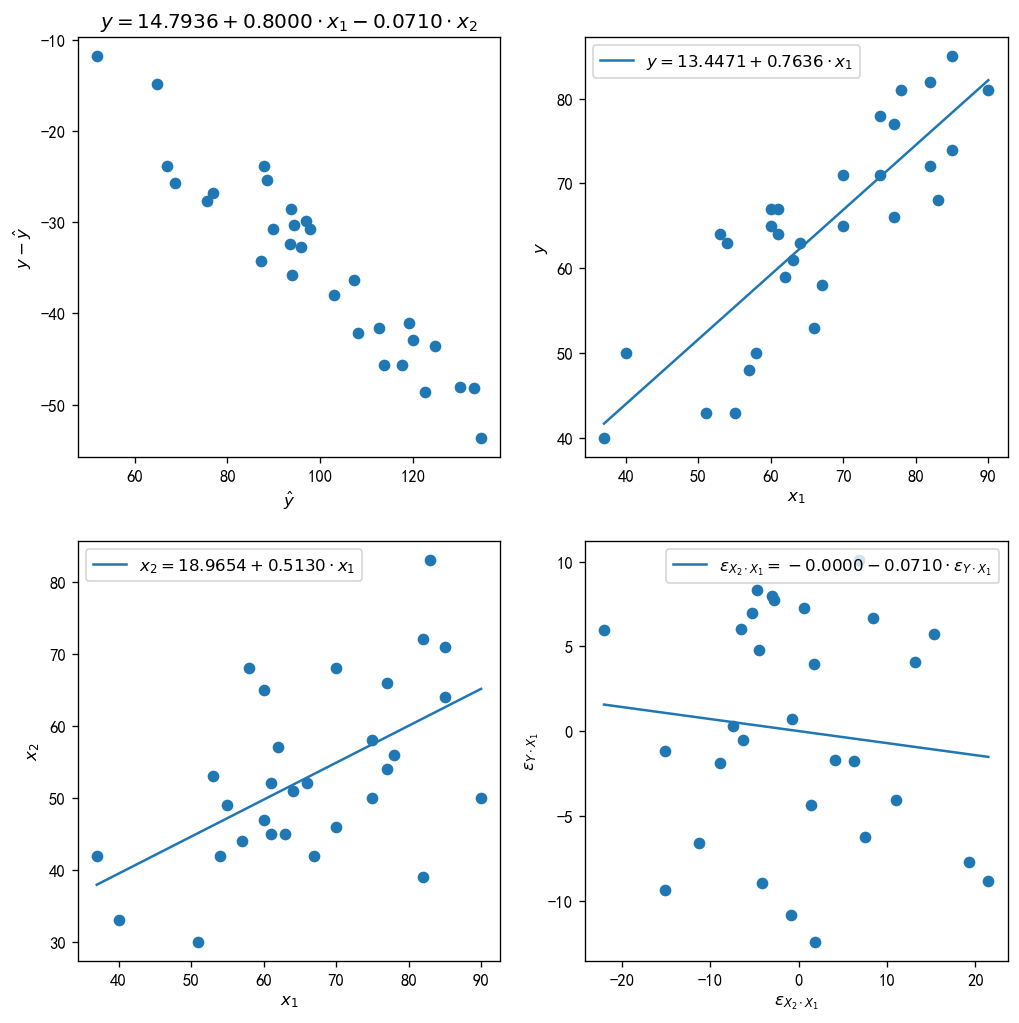

In [3]:
def test1():
    # columns: y, x1, x2
    data = pd.DataFrame(np.array([
        43, 51, 30,
        63, 64, 51,
        71, 70, 68,
        61, 63, 45,
        81, 78, 56,
        43, 55, 49,
        58, 67, 42,
        71, 75, 50,
        72, 82, 72,
        67, 61, 45,

        64, 53, 53,
        67, 60, 47,
        59, 62, 57,
        68, 83, 83,
        77, 77, 54,
        81, 90, 50,
        74, 85, 64,
        65, 60, 65,
        65, 70, 46,
        50, 58, 68,

        50, 40, 33,
        64, 61, 52,
        53, 66, 52,
        40, 37, 42,
        63, 54, 42,
        66, 77, 66,
        78, 75, 58,
        48, 57, 44,
        85, 85, 71,
        82, 82, 39,
    ]).reshape(-1, 3), columns='y x1 x2'.split())
    y    = data.y
    x1   = data.x1
    x2   = data.x2
    x1x2 = data['x1 x2'.split()]

    plt.figure(figsize=(10,10), dpi=120)

    # --- fig 1 ---
    plt.subplot(2, 2, 1)
    ols_yx1x2 = ordinary_least_squares(x1x2, y)
    print('ols_yx1x2:', ols_yx1x2)
    y_hat = ols_yx1x2.coef[0] - np.matmul(x1x2, ols_yx1x2.coef[1:])
    plt.scatter(y - y_hat, y_hat)
    plt.xlabel('$\hat{y}$')
    plt.ylabel('$y - \hat{y}$')
    plt.title('$y = %.4f %+.4f \cdot x_1 %+.4f \cdot x_2$' % (ols_yx1x2.coef[0], ols_yx1x2.coef[1], ols_yx1x2.coef[2]))

    # --- fig 2 ---
    plt.subplot(2, 2, 2)
    ols_yx1  = ordinary_least_squares(x1, y)
    #print('ols_yx1:', ols_yx1)
    plt.scatter(x1, y)
    new_x = np.linspace(x1.min(), x1.max(), 100)
    new_y = ols_yx1.coef[0] + ols_yx1.coef[1] * new_x
    plt.plot(new_x, new_y, label='$y = %.4f %+.4f \cdot x_1$' % (ols_yx1.coef[0], ols_yx1.coef[1]))
    plt.xlabel('$x_1$')
    plt.ylabel('$y$')
    plt.legend(loc='best')

    e_y_x1 = y - ols_yx1.coef[0] - ols_yx1.coef[1] * x1

    # --- fig 3 ---
    plt.subplot(2, 2, 3)
    ols_x2x1 = ordinary_least_squares(x1, x2)
    #print('ols_x2x1:', ols_x2x1)
    plt.scatter(x1, x2)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    new_x = np.linspace(x1.min(), x1.max(), 100)
    new_y = ols_x2x1.coef[0] + ols_x2x1.coef[1] * new_x
    plt.plot(new_x, new_y, label='$x_2 = %.4f %+.4f \cdot x_1$' % (ols_x2x1.coef[0], ols_x2x1.coef[1]))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='best')

    e_x2_x1 = x2 - ols_x2x1.coef[0] - ols_x2x1.coef[1] * x1

    # --- fig 4 ---
    plt.subplot(2, 2, 4)
    ols_3 = ordinary_least_squares(e_x2_x1, e_y_x1)
    #print('ols_3:', ols_3)
    plt.scatter(e_x2_x1, e_y_x1)
    new_x = np.linspace(e_x2_x1.min(), e_x2_x1.max(), 100)
    new_y = ols_3.coef[0] + ols_3.coef[1] * new_x
    plt.plot(new_x, new_y, label='$\epsilon_{X_2 \cdot X_1} = %.4f %+.4f \cdot \epsilon_{Y \cdot X_1}$' % (ols_3.coef[0], ols_3.coef[1]))
    plt.xlabel('$\epsilon_{X_2 \cdot X_1}$')
    plt.ylabel('$\epsilon_{Y \cdot X_1}$')
    plt.legend(loc='best')

    print('ols_3:', ols_3)

test1()

    weight  age  sbp
0        2  5.0    0
1       33  2.0   21
2       21  2.0    4
3       15  3.0    6
4        8  3.0   -3
5       11  5.0    5
6       -1  6.0    3
7        8  5.0    5
8       20  4.0   12
9        3  5.5    3
10      14  4.0   12
11      40  4.0   35
12      35  2.0   27
OrdinaryLeastSquares(coef=array([-22.72149874,   1.06827907,   4.00216155]), sigma=2.853595738694126, sigma_squared=8.143008639893276, f_value=87.84037797728628, p_value=4.5307022511487105e-07, r2=0.9461441227520286, t_values=array([-5.15293281, 12.18506139,  4.80958227]), p_values=array([2.14806180e-04, 1.26473873e-07, 3.56645514e-04]))


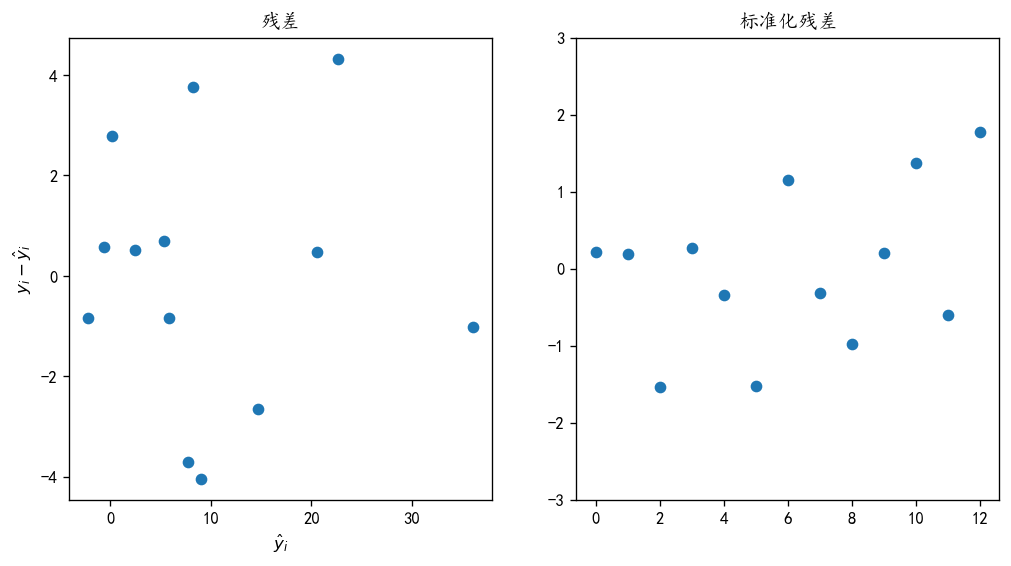

In [4]:
def test2():
    data = pd.DataFrame(np.array([
        152, 50, 120,
        183, 20, 141,
        171, 20, 124,
        165, 30, 126,
        158, 30, 117,

        161, 50, 125,
        149, 60, 123,
        158, 50, 125,
        170, 40, 132,
        153, 55, 123,
        
        164, 40, 132,
        190, 40, 155,
        185, 20, 147,
    ]).reshape(-1, 3), columns='weight age sbp'.split())

    data2 = data.copy()
    if 1:
        data2.weight -= 150
        data2.age /= 10
        data2.sbp -= 120
    else:
        data2.weight = (data2.weight - data2.weight.mean()) / data2.weight.std()
        data2.age    = (data2.age - data2.age.mean()) / data2.age.std()
        data2.sbp    = (data2.sbp - data2.sbp.mean()) / data2.sbp.std()
    print(data2)
    ols = ordinary_least_squares(data2[['weight', 'age']], data2['sbp'])
    print(ols)

    plt.figure(figsize=(10,5), dpi=120)

    plt.subplot(1, 2, 1)
    plt.title('残差')
    y_hat = ols.coef[0] + np.matmul(data2[['weight', 'age']], ols.coef[1:])
    plt.scatter(y_hat, data2.sbp - y_hat)
    plt.xlabel('$\hat{y}_i$')
    plt.ylabel('$y_i - \hat{y}_i$')

    # 残差分析，标准化残差
    plt.subplot(1, 2, 2)
    plt.title('标准化残差')
    x_design     = np.hstack([np.ones([data2.shape[0], 1]), data2[['weight', 'age']] ])
    hat_matrix   = np.linalg.inv(np.matmul(x_design.T, x_design))
    hat_matrix   = np.matmul(x_design, hat_matrix)
    hat_matrix   = np.matmul(hat_matrix, x_design.T)
    diag_values  = np.array([hat_matrix[i,i] for i in range(data2.shape[0])])
    residual     = data2['sbp'] - y_hat
    std_residual = residual / (ols.sigma * np.sqrt(1 - diag_values))
    plt.scatter(np.arange(data2.shape[0]), std_residual)
    plt.ylim(-3, 3)

test2()

确认标准化残差基本在 $\pm 2 \sigma $ 范围内，且不存在明显的趋势。

In [5]:
def test3():
    data = np.array([
        75.2, 30.6, 21.1, 1090.4,
        77.6, 31.3, 21.4, 1133.0,
        80.7, 33.9, 22.9, 1242.1,
        76.0, 29.6, 21.4, 1003.2,
        79.5, 32.5, 21.5, 1283.2,

        81.8, 27.9, 21.7, 1012.2,
        98.3, 24.8, 21.5, 1098.8,
        67.7, 23.6, 21.0,  826.3,
        74.0, 33.9, 22.4, 1003.3,
        151.0, 27.7, 24.7, 1554.6,

        90.8, 45.5, 23.2, 1199.0,
        102.3, 42.6, 24.3, 1483.1,
        115.6, 40.0, 23.1, 1407.1,
        125.0, 45.8, 29.1, 1551.3,
        137.8, 51.7, 24.6, 1601.2,

        175.6, 67.2, 27.5, 2311.7,
        155.2, 65.0, 26.5, 2126.7,
        174.3, 65.4, 26.8, 2256.5
    ]).reshape(-1, 4)
    data = pd.DataFrame(data, columns='x1 x2 x3 y'.split())
    ols = ordinary_least_squares(data['x1 x2 x3'.split()], data.y)
    print(ols)

test3()

OrdinaryLeastSquares(coef=array([162.06315345,   7.27385503,  13.9574624 ,  -4.39955926]), sigma=100.3891766532253, sigma_squared=10077.986789112478, f_value=105.08665208906233, p_value=7.746546737408266e-10, r2=0.9574804049702317, t_values=array([ 0.46818412,  5.37872211,  4.407114  , -0.2226545 ]), p_values=array([3.23429263e-01, 4.86367391e-05, 2.98295679e-04, 4.13510019e-01]))
